In [1]:
import torch 
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
import json
import pickle
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report

/Users/bharathshankar/Documents/Y3S1 Mods/UROPS/Patient-Rep-UROPS/uropVenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATIENT_LIST = '../data/dataByPatient/patientList.pkl'
with open(PATIENT_LIST, 'rb') as pickle_file:
    patientList = pickle.load(pickle_file) 

random.Random(42).shuffle(patientList)

test_data = patientList[44000:]
adm_data = pd.read_csv("../data/patientData/ADMISSIONS.csv")

In [3]:
adm_type = []
for i in test_data:
    adm_type.append(adm_data[adm_data["SUBJECT_ID"] == i]["ADMISSION_TYPE"].iloc[0])

In [4]:
def convert_str(x):
    return json.loads("".join(x[7:-1].split("\n")))
def convert_val(x):
    return float(x[8:-2])
def convert_val_out(x):
    return int(x[8:-2])

In [5]:
beta0_res = pd.read_csv("../Results/beta0.csv")
beta0_res = beta0_res[["embeddings", "prediction", "actual"]]
beta0_res["embeddings"] = beta0_res[["embeddings"]].apply(
    lambda x: [convert_str(y) for y in x]
)
beta0_res[["prediction", "actual"]] = beta0_res[["prediction", "actual"]].apply(
    lambda x: [convert_val(y) for y in x]
)
beta0_res["Adm_Type"] = adm_type
beta0_res["Adm_Type"] = LabelEncoder().fit_transform(beta0_res["Adm_Type"].astype("category"))

In [6]:
beta0_res

,embeddings,prediction,actual,Adm_Type
0,"[1.1879, -1.9835, 20.585, -5.9935, 6.6371, -2....",0.0451,0.0,1
1,"[29.183, -7.5059, 40.311, 0.011579, -23.03, 3....",0.8711,1.0,1
2,"[-0.0828, 3.5813, 9.1339, -7.9791, -0.065, -4....",0.6436,0.0,1
3,"[6.4445, 4.7176, 37.8902, -23.2115, -48.9313, ...",0.5492,1.0,1
4,"[-1.1943, 1.4295, 14.4, -8.1377, 2.6219, -4.05...",0.0987,0.0,1
...,...,...,...,...
2515,"[9.9697, -6.1723, 14.064, 2.4629, 6.3768, 2.34...",0.8805,1.0,1
2516,"[8.8731, -5.1517, 13.7814, 8.5331, 2.9825, 0.8...",0.8269,1.0,1
2517,"[-2.5339, 3.8198, 20.3302, 20.4052, -2.9296, -...",0.5253,1.0,1
2518,"[2.4191, -2.8538, 20.105, -2.3745, 11.12, 0.24...",0.0032,0.0,2


In [7]:
roc_auc_score(beta0_res["actual"].apply(int), beta0_res["prediction"])

0.8198400286944045

In [8]:
beta0_res["actual"].apply(int)

0       0
1       1
2       0
3       1
4       0
       ..
2515    1
2516    1
2517    1
2518    0
2519    1
Name: actual, Length: 2520, dtype: int64

Text(0.5, 1.0, 'Confusion Matrix')

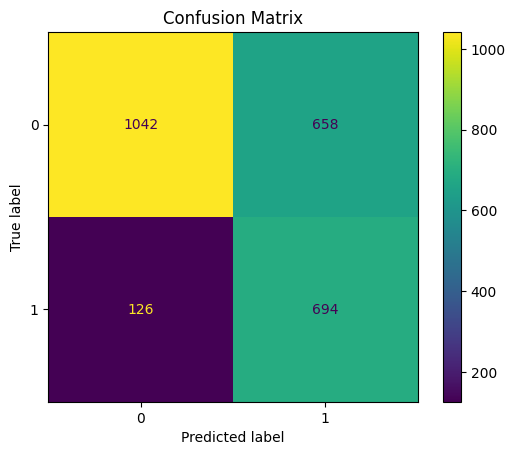

In [9]:
disp = ConfusionMatrixDisplay.from_predictions(
 beta0_res["actual"].apply(int), beta0_res["prediction"].apply(round))
disp.ax_.set_title("Confusion Matrix")

Text(0.5, 1.0, 'AUC-ROC Curve')

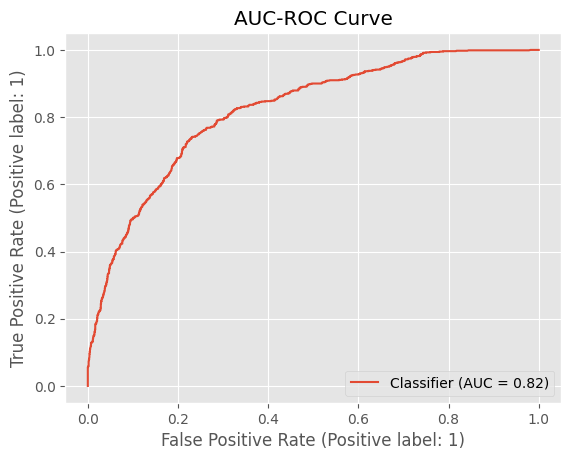

In [10]:
plt.style.use('ggplot')
disp = RocCurveDisplay.from_predictions(
 beta0_res["actual"].apply(int), beta0_res["prediction"], )
disp.ax_.set_title("AUC-ROC Curve")

In [11]:
print(classification_report(beta0_res["actual"].apply(int), beta0_res["prediction"].apply(round)))

              precision    recall  f1-score   support

           0       0.89      0.61      0.73      1700
           1       0.51      0.85      0.64       820

    accuracy                           0.69      2520
   macro avg       0.70      0.73      0.68      2520
weighted avg       0.77      0.69      0.70      2520



In [12]:
emb_dat = np.array(list(beta0_res["embeddings"].values))
tSNE_dat = TSNE(2, perplexity = 40, init = "pca").fit_transform(emb_dat)

/Users/bharathshankar/Documents/Y3S1 Mods/UROPS/Patient-Rep-UROPS/uropVenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/bharathshankar/Documents/Y3S1 Mods/UROPS/Patient-Rep-UROPS/uropVenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [13]:
tSNE_dat.shape

(2520, 2)

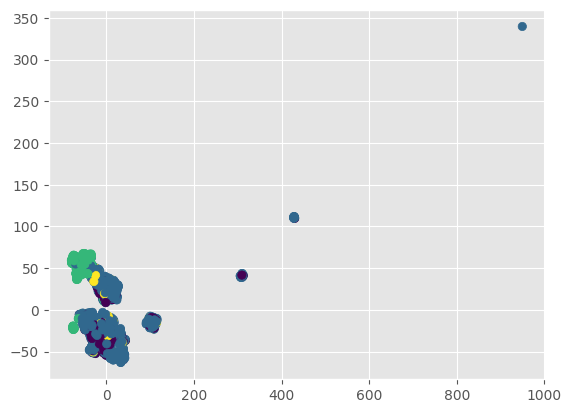

In [14]:
plt.scatter(tSNE_dat[:, 0], tSNE_dat[:, 1], c = beta0_res["Adm_Type"])

In [19]:
pd.read_json(
    "../checkpoint/tune_MIMIC/train_model_2c545_00000_0_batch_size=16,beta=2,embedDim=512,finalDim=120,lr=0.0000,num_epochs=10,num_layers=4,wd=0.0000_2022-11-20_02-08-30/result.json",
    lines=True
)


,loss,mean_accuracy,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,...,timestamp,time_total_s,pid,hostname,node_ip,config,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,0.559345,0.72600,2519.648783,True,False,NaN,NaN,1,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 18:50:34,2519.648783,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",2519.648783,0,1,0.003633
1,0.539680,0.72750,2657.766961,True,False,NaN,NaN,2,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 19:34:52,5177.415744,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",5177.415744,0,2,0.003633
2,0.520899,0.73650,2654.775583,True,False,NaN,NaN,3,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 20:19:07,7832.191327,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",7832.191327,0,3,0.003633
3,0.547510,0.73550,2640.054673,True,False,NaN,NaN,4,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 21:03:07,10472.246000,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",10472.246000,0,4,0.003633
4,0.506329,0.74825,2601.775525,True,False,NaN,NaN,5,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 21:46:29,13074.021526,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",13074.021526,0,5,0.003633
5,0.556977,0.73025,2724.012387,True,False,NaN,NaN,6,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 22:31:53,15798.033913,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",15798.033913,0,6,0.003633
6,0.511723,0.74950,3125.624431,True,False,NaN,NaN,7,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-19 23:23:58,18923.658344,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",18923.658344,0,7,0.003633
7,0.477834,0.76750,3390.671004,True,False,NaN,NaN,8,2c545_00000,fc2097265e0548a08977f80ccf8f6ceb,...,2022-11-20 00:20:29,22314.329348,386483,volta07,172.18.126.104,"{'num_layers': 4, 'embedDim': 512, 'finalDim':...",22314.329348,0,8,0.003633


In [ ]:
!tensorboard --logdir=../checkpoint/tune_MIMIC

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)
